<a href="https://colab.research.google.com/github/adowling2/batch-crystallizer/blob/main/batch_crystalliser_pyomo_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Crystalliser in Pyomo

Cameron Brown (cameron.brown.100@strath.ac.uk), Aaron Bjarnason (aaron.bjarnason@strath.ac.uk), Alex Dowling (adowling@nd.edu), Hailey Lynch (hlynch@nd.edu), Dan Laky (dlaky@nd.edu)


This file:
 1. Simulates crystallization experiments, and adds measurement noise to the data.
 2. Estimates the kinetic parameters using the collected data (parmest).
 3. Uses model based design of experiments to optimize experimental design to achieve 'maximum' refinement of parameter estimations (Pyomo.DOE). 

 Requires files: 'Cryst_model.py', 'Cryst_model_plot.py'

==== Current build, VSC_01_Obj_Test: replacing Cryst_model_parmest into main body ====

Changes from Batch Crystallizer V7: 
- Separates out functions into separate scripts
- Added code for inital seeding conditions to Cryst_model
- Built on foundations of MB-DoE framework

Current Issues:
- Cannot generate experiment to debug/improve/expand MB-DoE framework
    - FIM generated from current setup gives 'zero matrix'
    - More experiments required for more 'information'?

Other notes:
- Unsure if removing the functions into separate files (which will require importing packages e.g 'import numpy as np' each time) will make the system much less efficient.
    - Might not be a big issue unless we have many visits to the function file.

## Setup Environment

In [1]:
# Imports

import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import pyomo.environ as pyo
from pyomo.dae import *
from pyomo.contrib.doe import (ModelOptionLib, DesignOfExperiments, MeasurementVariables, DesignVariables)

# Function files - newly separated from main body
from Cryst_model import *
from Cryst_model_plot import *
# from Cryst_model_parmest import *

## Define Typical Experiment and Model

Typical experiment and model now defined within Cryst_model.py

In [2]:
m = Cryst_model(exp_conditions=exp)

### Simulate Model

Now, simulate the model.

In [3]:
# Specify integrator options
int_ops = {'print_stats':True}

# Solve using simulator
sim = Simulator(m, package='casadi')
tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 665
Number of calls to the user's f function: 1268
Number of calls made to the linear solver setup function: 87
Number of error test failures: 26
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 0.00172767
Step size taken on the last internal step: 15.3496
Step size to be attempted on the next internal step: 30.6992
Current internal time reached: 7200
Number of nonlinear iterations performed: 1266
Number of nonlinear convergence failures: 0



CasADi - 2024-03-12 20:45:40 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


### Plot function

Plotting function now within Cryst_model_plot.py

### Simulator results

[   0.           72.72727273  145.45454545  218.18181818  290.90909091
  363.63636364  436.36363636  509.09090909  581.81818182  654.54545455
  727.27272727  800.          872.72727273  945.45454545 1018.18181818
 1090.90909091 1163.63636364 1236.36363636 1309.09090909 1381.81818182
 1454.54545455 1527.27272727 1600.         1672.72727273 1745.45454545
 1818.18181818 1890.90909091 1963.63636364 2036.36363636 2109.09090909
 2181.81818182 2254.54545455 2327.27272727 2400.         2472.72727273
 2545.45454545 2618.18181818 2690.90909091 2763.63636364 2836.36363636
 2909.09090909 2981.81818182 3054.54545455 3127.27272727 3200.
 3272.72727273 3345.45454545 3418.18181818 3490.90909091 3563.63636364
 3636.36363636 3709.09090909 3781.81818182 3854.54545455 3927.27272727
 4000.         4072.72727273 4145.45454545 4218.18181818 4290.90909091
 4363.63636364 4436.36363636 4509.09090909 4581.81818182 4654.54545455
 4727.27272727 4800.         4872.72727273 4945.45454545 5018.18181818
 5090.90909091

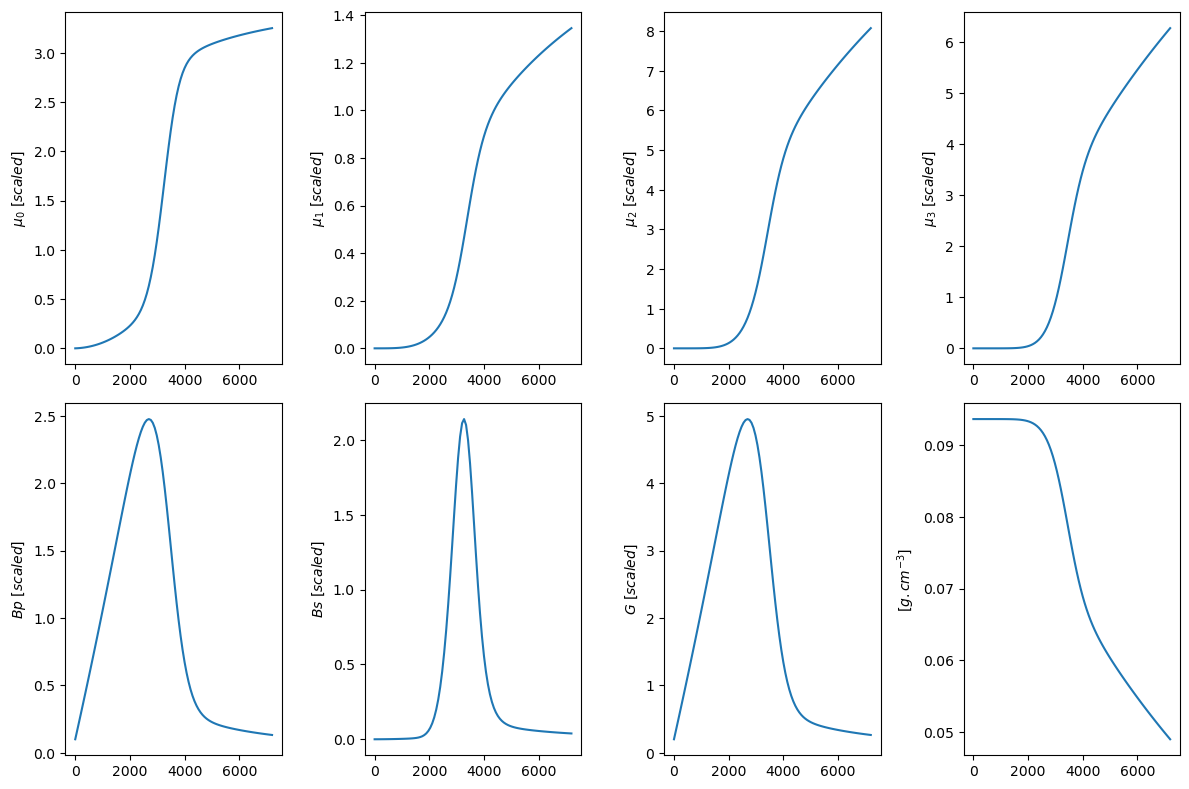

In [4]:
# Simulate results
sim_results = Results(m)
sim_results.load_from_simulator(tsim,profiles)
sim_results.plot(undo_scaling=False)

In [5]:
df=sim_results.to_pandas()
# df.head()
# df.to_csv(r'drive/MyDrive/data_beta_1.csv',index=False)

### Temperature profile testing

In [6]:
# Temperature profile testing
Ti      = 323.9     # initial temperature [K]
Te      = 293       # final temperature [K]
n       = 6         # cooling profile order [-]

# Small experiment with Pyomo.DAE
'''
m = pyo.ConcreteModel()

m.t = ContinuousSet(bounds=(0, tau))

m.T = pyo.Var(m.t, initialize = Ti, within = pyo.NonNegativeReals)
# m.mu0 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)
# m.dmu0 = DerivativeVar(m.mu0)

@m.Constraint(m.t)
def temperature(m, t):
    return m.T[t] == Ti - (Ti - Te)*(t / tau)**n

# @m.Constraint(m.t)
# def ode1(m, t):
#     return m.dmu0[t] == 1e12

# m.mu0[0.0].fix(0)


pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, scheme='BACKWARD')

pyo.SolverFactory('ipopt').solve(m)

t_values = [t for t in m.t]
# mu0_values = [m.mu0[t]() for t in m.t]
T_values = [m.T[t]() for t in m.t]

plt.plot(t_values, T_values)
plt.show()

'''

"\nm = pyo.ConcreteModel()\n\nm.t = ContinuousSet(bounds=(0, tau))\n\nm.T = pyo.Var(m.t, initialize = Ti, within = pyo.NonNegativeReals)\n# m.mu0 = pyo.Var(m.t, initialize = 0, within = pyo.NonNegativeReals)\n# m.dmu0 = DerivativeVar(m.mu0)\n\n@m.Constraint(m.t)\ndef temperature(m, t):\n    return m.T[t] == Ti - (Ti - Te)*(t / tau)**n\n\n# @m.Constraint(m.t)\n# def ode1(m, t):\n#     return m.dmu0[t] == 1e12\n\n# m.mu0[0.0].fix(0)\n\n\npyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, scheme='BACKWARD')\n\npyo.SolverFactory('ipopt').solve(m)\n\nt_values = [t for t in m.t]\n# mu0_values = [m.mu0[t]() for t in m.t]\nT_values = [m.T[t]() for t in m.t]\n\nplt.plot(t_values, T_values)\nplt.show()\n\n"

## Numerical Integration with Ipopt

### Discretize

In [7]:
# Discretization using finite difference
# Add an objective. This is helpful for Degeneracy Hunter
m.obj = pyo.Objective(expr=1)

# Discretize the model
# discretizer = pyo.TransformationFactory('dae.collocation')
# discretizer.apply_to(m,nfe=100,scheme='LAGRANGE-RADAU',ncp=3)
pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')

# Initialize the model using the simulated profile
# https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html#from-simulation
sim.initialize_model()

### Check initialization at iteration 0

In [8]:
# Ipopt solver
solver = pyo.SolverFactory('ipopt')
#solver.options = {'bound_push':1E-8, 'max_iter':3000}

# Use on Colab
# solver.options = {'max_iter':500, 'linear_solver':'ma97'}

# Use locally (no HSL)
solver.options = {'max_iter':1000, 'linear_solver':'mumps'}

solver.solve(m,tee=True)

Ipopt 3.11.1: max_iter=1000
linear_solver=mumps


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     5908
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1200

Total number of variables............................:     2012
                     variables with only lower bounds:     1204
                variables with

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2012, 'Number of variables': 2012, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.1932225227355957}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Check Residuals (Optional)

In [9]:
if False:
    # Declare MILP solver (for DH)
    milp_solver = pyo.SolverFactory('cbc')

    # Create Degeneracy Hunter object
    from idaes.core.util.model_diagnostics import DegeneracyHunter
    dh = DegeneracyHunter(m, solver=milp_solver)

    # Print out equations with large residuals at the first iteration
    dh.check_residuals(tol=0.1)

### Plot Results

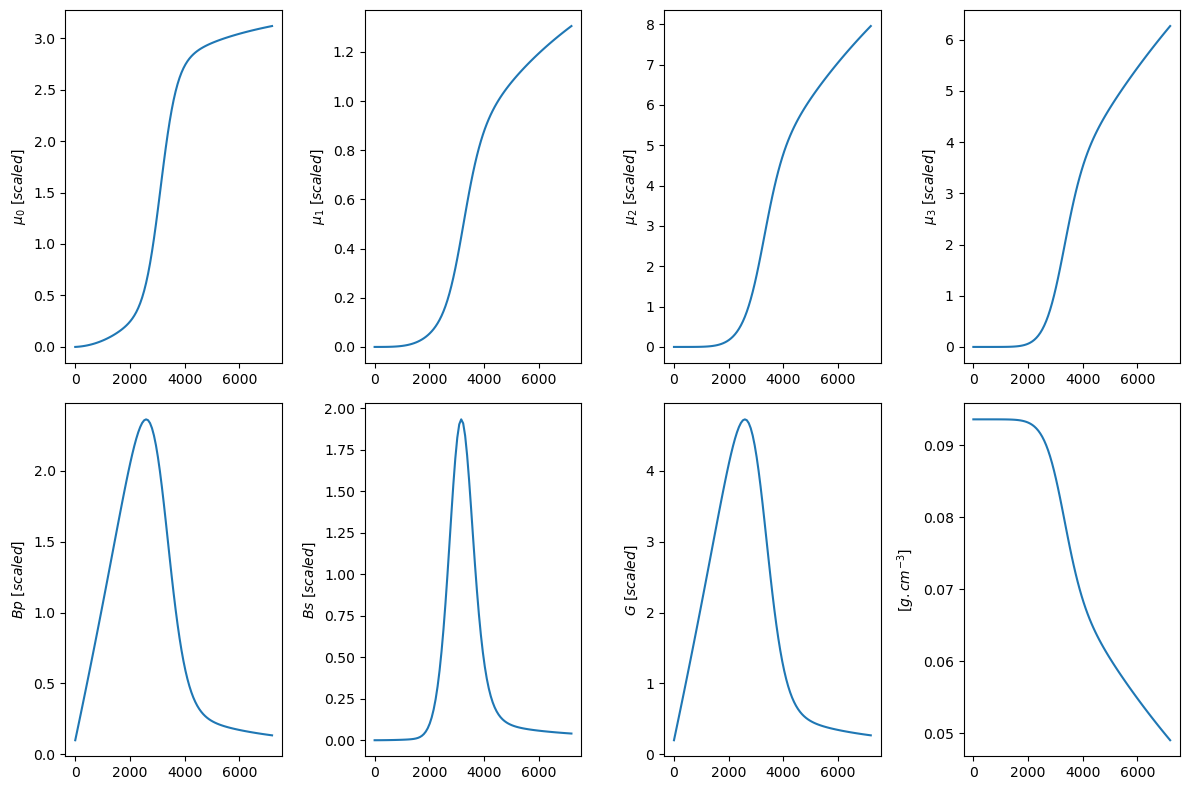

In [10]:
# Plot results
pyo_results = Results(m)
pyo_results.load_from_pyomo_model(m)
pyo_results.plot(undo_scaling=False)
# modify plot function, show data as the dots for the regression (concentration plot with saturation)

## Dynamic Optimization

## Parameter Estimation

### Generate Data

https://ndcbe.github.io/optimization/notebooks/5/Parmest-generate-data.html



In [11]:
typical_experiment()

{'Ci': 0.11668,
 'Ti': 323.9,
 'tau': 7200,
 'beta': 0.0016666666666666668,
 'eps': 0.0005,
 'M_seed': 0,
 'Ls': 0.02}

In [12]:
exp1 = typical_experiment()
# exp1['Ci'] = 200 * 1e-3
# exp1['Ti'] = 300

exp1['Ci'] = 160 * 1e-3
exp1['Ti'] = 330

exp2 = typical_experiment()
# exp2['Ci'] = 150 * 1e-3
# exp2['Ti'] = 290

exp2['Ci'] = 100 * 1e-3
exp2['Ti'] = 320

experiments = [exp1, exp2]

list_of_exp_data_frames = []
for i, exp in enumerate(experiments):

    print("\n***** Considering experiment",i+1," *****")

    # Create Pyomo model
    m = Cryst_model(exp_conditions=exp)

    # Numerical intergrate to initialize

    # Solve using simulator
    int_ops = {'print_stats':True}
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=100, integrator = 'idas', integrator_options=int_ops)

    # Discretize
    m.obj = pyo.Objective(expr=1)
    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, scheme='BACKWARD')
    sim.initialize_model()

    # Solve with Ipopt
    solver = pyo.SolverFactory('ipopt')
    solver.solve(m,tee=True)

    # Extract results
    results = Results(m)
    results.load_from_pyomo_model(m)

    n = len(results.mu3)
    mu4_div_mu3 = np.zeros(n)
    for i in range(n):
        mu4_div_mu3[i] = results.mu4[i]/(results.mu3[i] + 1e-8)

    # Add noise to data
    def add_noise(vector):
        return np.array(vector) + np.random.normal(0, 0.05*np.std(vector), len(vector))

    C = add_noise(results.C)
    MT = add_noise(results.MT)
    mu4_div_mu3 = add_noise(mu4_div_mu3)

    Ci = np.ones(n)*exp['Ci']
    Ti = np.ones(n)*exp['Ti']

    df_temp = pd.DataFrame({"time":results.time,"C":C,"MT":MT,"avg_volume":mu4_div_mu3,"Ci":Ci,"Ti":Ti})
    display(df_temp)

    list_of_exp_data_frames.append(df_temp)





***** Considering experiment 1  *****
FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 802
Number of calls to the user's f function: 1361
Number of calls made to the linear solver setup function: 88
Number of error test failures: 27
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 0.00172767
Step size taken on the last internal step: 79.1186
Step size to be attempted on the next internal step: 158.237
Current internal time reached: 7200
Number of nonlinear iterations performed: 1359
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
**************************************************

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.129754,-0.001012,0.000171,0.16,330.0
1,72.0,0.133760,0.000174,-0.017840,0.16,330.0
2,144.0,0.130848,0.001801,0.014467,0.16,330.0
3,216.0,0.132464,0.000969,0.014938,0.16,330.0
4,288.0,0.130908,0.000563,0.020832,0.16,330.0
...,...,...,...,...,...,...
96,6912.0,0.069963,0.060271,0.939559,0.16,330.0
97,6984.0,0.069924,0.060039,0.958800,0.16,330.0
98,7056.0,0.069682,0.061438,0.959089,0.16,330.0
99,7128.0,0.068404,0.061859,0.941668,0.16,330.0



***** Considering experiment 2  *****
FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 794
Number of calls to the user's f function: 1367
Number of calls made to the linear solver setup function: 87
Number of error test failures: 30
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 0.00172766
Step size taken on the last internal step: 51.6286
Step size to be attempted on the next internal step: 51.6286
Current internal time reached: 7200
Number of nonlinear iterations performed: 1365
Number of nonlinear convergence failures: 0

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
**************************************************

,time,C,MT,avg_volume,Ci,Ti
0,0.0,0.075809,0.000010,0.024835,0.1,320.0
1,72.0,0.076074,-0.000263,0.031329,0.1,320.0
2,144.0,0.075190,-0.000054,0.016972,0.1,320.0
3,216.0,0.076055,-0.000068,-0.001575,0.1,320.0
4,288.0,0.075525,-0.000861,0.011308,0.1,320.0
...,...,...,...,...,...,...
96,6912.0,0.040418,0.034508,0.933127,0.1,320.0
97,6984.0,0.039960,0.034525,0.926640,0.1,320.0
98,7056.0,0.040547,0.035215,0.942801,0.1,320.0
99,7128.0,0.039100,0.035959,0.958059,0.1,320.0


### Estimate with Parmest

https://ndcbe.github.io/optimization/notebooks/5/Parmest-tutorial.html


In [13]:
def Cryst_model_parmest(data):
    '''
    Special create_model function for parmest
    '''
    ## Setup experiment model
    exp = typical_experiment()
    exp['Ci'] = data.Ci.iloc[0]
    exp['Ti'] = data.Ti.iloc[0]

    m = Cryst_model(exp_conditions=exp,time_points=data.time.to_list())

    ## Numerical intergrate to initialize

    # Solve using simulator
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(integrator = 'idas')

    ## Discretize
    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100,scheme='BACKWARD')
    sim.initialize_model()
    ## Prepare data

    C_measure={}
    MT_measure={}
    avg_vol_measure={}
    t_measure = data.time.to_list()
    for i,t in enumerate(data.time):
        C_measure[float(t)] = data.Ci[i]
        MT_measure[float(t)] = data.MT[i]
        avg_vol_measure[float(t)] = data.avg_volume[i]

    # Least squares objective

    def ComputeFirstStageCost_rule(m):
        return 0
    m.FirstStageCost = pyo.Expression(rule=ComputeFirstStageCost_rule)

    def ComputeSecondStageCost_rule(m):
      # measurements
        return sum((m.C[t] - C_measure[t]) ** 2 + (m.MT[t] - MT_measure[t]) ** 2
                       + (m.avg_vol[t] - avg_vol_measure[t]) ** 2 for t in t_measure)
        # return sum((m.C[t] - C_measure[t]) ** 2
                      #  + (100 * m.avg_vol[t] - 100 * avg_vol_measure[t]) ** 2 for t in t_measure)
    m.SecondStageCost = pyo.Expression(rule=ComputeSecondStageCost_rule)

    # return the sum of the first-stage and second-stage costs as the objective function
    def total_cost_rule(m):
        return m.FirstStageCost + m.SecondStageCost

    m.total_cost_objective = pyo.Objective(rule=total_cost_rule, sense=pyo.minimize)

    return m

In [14]:
import pyomo.contrib.parmest.parmest as parmest

# defining the names of the parameters in a list
theta_names = list(m.theta.keys())
# theta_names = ['b1','b2','kg','g']
print(theta_names)

# create an object using parmest.Estimator() that stores the Pyomo model realizations for the datasets provided.
# This object which will be used to determined the parameter values that best fit all the datasets
pest = parmest.Estimator(Cryst_model_parmest,list_of_exp_data_frames,theta_names,tee=True,solver_options={'halt_on_ampl_error':'yes',
                                                                                                           'linear_solver': 'ma97'})

# call the method theta_est() for the Estimator() object defined above to solve
# the parameter estimation problem.
# theta_est() returns:
    # the overall objective function value
    # estimated parameter values (dictionary with keys = parameters names as defined in the Pyomo model)
obj, theta = pest.theta_est()

print('theta:\n',theta)


['kb1', 'b1', 'kb2', 'b2', 'kg', 'g']
Ipopt 3.11.1: halt_on_ampl_error=yes
linear_solver=ma97


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:    13040
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5420

Total number of variables............................:     4036
                     variables with only lower bo

In [15]:
Estimates = {'kb1': np.exp(theta[0]), 'b1': theta[1], 'kb2': np.exp(theta[2]), 'b2': theta[3], 'kg': np.exp(theta[4]), 'g': theta[5]} 
print('Estimates:\n',Estimates)

Estimates:
 {'kb1': 10.000020319542081, 'b1': 3.766246445091517, 'kb2': 1000000.991317617, 'b2': 1.9803523213745553, 'kg': 0.0025686917429381478, 'g': 1.0475657166330827}


# Model-based Design of Experiments

In [16]:
# Gather time points you want. Probably can specify from the model(??)
time_control = []
old_div = -1
for i in range(51):
    if int(i * 144 / 900) != old_div:
      old_div = int(i * 144 / 900)
      time_control.append(i * 144)

time_control = [0] #override line for MBDoE development - initial condition only

print(time_control)
# Defining the control time set (hours)
#time_control = [0, 0.25, 0.50, 0.75, 1]

# Defining parameter nominal value
parameter_dict = {'kb1':10,'b1':0.1,'kb2':100,'b2': 0.2, 'kg': 0.00002, 'g': 0.54641}

parameter_dict = dict(theta)

[0]


In [17]:
# Defining measurements (physically measuring -- need to change)
measurement_class = MeasurementVariables()

variable_name='C'
#sum((m.C[t] - C_measure[t]) ** 2 + (m.MT[t] - MT_measure[t]) ** 2
 #                      + (m.avg_vol[t] - avg_vol_measure[t]) ** 2 for t in t_measure)
indices = {0:time_control}

# Adding measurements variables
measurement_class.add_variables('C',indices=indices, time_index_position=0,variance=1e-1*0.05)  # From ~avg. concentration * 0.05
measurement_class.add_variables('MT',indices=indices, time_index_position=0,variance=1e-1*0.05) # Same as concentration
measurement_class.add_variables('avg_vol',indices=indices, time_index_position=0,variance=1e-3) # TODO: need to fix variance; find what a reasonable variance would be
print('Measurement names:', measurement_class.variable_names)

Measurement names: ['C[0]', 'MT[0]', 'avg_vol[0]']


In [18]:
# Design variables (manipulate to make experiment more informative -- Ci is fine for now)
design_vars = DesignVariables()

var_C = 'Ci'
indices_C = [0, ]
exp1_C = [95e-3, ]

In [19]:
# Add design variable
# design_vars.add_variables(var_C,
#                          indices = {0:indices_C},
#                          time_index_position=0,
#                          values=exp1_C,lower_bounds=90e-3, upper_bounds=100e-3)


# Line 176 in measurements.py (should perform assertion that time_index_position is iterable before calling 'is in')

In [20]:
var_T = 'Ti'
#indices_T = {0:time_control}
indices_T = {0:[0]}

In [21]:
#exp1_T = [470, 300, 300, 300, 300]
exp1_T = [325, ]

design_vars.add_variables(var_T, indices = indices_T, time_index_position=0, values=exp1_T,
                          lower_bounds=320, upper_bounds=330)  # What do these do?
print("Design variable names:", design_vars.variable_names)

# Strange error with partial variable names output such as 'T[' ??????

Design variable names: ['Ti[0]']


In [22]:
# dv_pass = {'Ti[0]': [0]} #building an initial input for MBDoE "design_vars"

In [23]:
# Sensitivity selection
sensitivity_option = 'sequential_finite'

# Define experiments
design_names = design_vars.variable_names
# exp1 = [130e-3, 325]
exp1 = [325]
exp1_design_dict = dict(zip(design_names, exp1))

print(exp1_design_dict)

# design_vars.update_values(exp1_design_dict)

{'Ti[0]': 325}


In [24]:
def disc_for_measure(m, nfe=50, block=True):
    """
    Pyomo.DAE discretization

    Arguments
    ---------
    m: Pyomo model
    nfe: number of finite elements b
    block: if True, the input model has blocks
    """
    # Discretization using collocation
    discretizer = pyo.TransformationFactory("dae.finite_difference")
    # nfe = 50
    # discretizer = pyo.TransformationFactory("dae.collocation")
    if block:
        for s in range(len(m.block)):
            discretizer.apply_to(m.block[s], nfe=nfe, wrt=m.block[s].t, scheme='BACKWARD')
            sim = Simulator(m.block[s], package='casadi')
            # discretizer.apply_to(m.block[s], nfe=nfe, ncp=3, wrt=m.block[s].t, scheme='LAGRANGE-RADAU')
            tsim, profiles = sim.simulate(numpoints=150, integrator = 'idas', integrator_options=int_ops)
            sim.initialize_model()
    else:
        # TODO: Add simulation to this case
        discretizer.apply_to(m, nfe=nfe, wrt=m.t, scheme='BACKWARD')
        # discretizer.apply_to(m.block[s], nfe=nfe, ncp=6, wrt=m.block[s].t, scheme='LAGRANGE-RADAU')
    return m

In [25]:
# Ipopt solver
solver = pyo.SolverFactory('ipopt')

solver.options = {'bound_push':1E-8, 'linear_solver':'mumps', 'max_iter':3000}

# Use on Colab
# solver.options = {'bound_push':1E-8,'max_iter': 500,
#                   'linear_solver':'ma97',
#                   'halt_on_ampl_error': 'yes'}

# DoE object
doe_object = DesignOfExperiments(parameter_dict,    # dictionary of parameters
                                 design_vars,       # design variables
                                 measurement_class, # measurements
                                 Cryst_model,       # model
                                 solver=solver,     # solver option
                                 discretize_model=disc_for_measure # discretization
                                 )

# Compute FIM
result = doe_object.compute_FIM(mode=sensitivity_option,        # sensitivity option
                                FIM_store_name = 'dynamic.csv', # FIM results
                                read_output=None,               # output
                                scale_nominal_param_value=True, # scaling
                                formula = "central"             # central finite difference
                                )

# FIM results
result.result_analysis()

WARNING (W1002): Setting Var 'block[1].kb1' to a numeric value
`2.300284537821243` outside the bounds (2.302585092994046, 9.210340371976184).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'block[5].kb2' to a numeric value
`13.801696037732118` outside the bounds (13.815510557964274,
27.631021115928547).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 695
Number of calls to the user's f function: 1334
Number of calls made to the linear solver setup function: 195
Number of error test failures: 81
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 0.0483221
Step size taken on the last internal step: 48.9324
Step size to be attempted on the next internal step: 48.9324
Current internal time reached: 7200
Number of nonlinear iterations performed: 1332
Number of nonlinear convergenc

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 763
Number of calls to the user's f function: 1727
Number of calls made to the linear solver setup function: 447
Number of error test failures: 211
Method order used on the last internal step: 3
Method order to be used on the next internal step: 3
Actual value of initial step size: 0.0483221
Step size taken on the last internal step: 64.0296
Step size to be attempted on the next internal step: 64.0296
Current internal time reached: 7200
Number of nonlinear iterations performed: 1725
Number of nonlinear convergence failures: 0

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 722
Number of calls to the user's f function: 1682
Number of calls made to the linear solver setup function: 440
Number of error test failures: 206
Method order used on the last internal step: 4
Method order to be used on the next internal step: 4
Actual value of initial step size: 0.0483221
Step size taken on the last internal step: 41.4572
Step size t

c:\Users\aaron\anaconda3\lib\site-packages\pyomo\contrib\doe\result.py:237: RuntimeWarning: invalid value encountered in double_scalars
  self.cond = max(eig) / min(eig)


In [26]:
# Results summary
print('======Results Summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))
print(result.FIM)

======Results Summary======
Four design criteria log10() value:
A-optimality: -inf
D-optimality: -inf
E-optimality: -inf
Modified E-optimality: nan
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


C:\Users\aaron\AppData\Local\Temp\ipykernel_10096\2226657694.py:4: RuntimeWarning: divide by zero encountered in log10
  print('A-optimality:', np.log10(result.trace))
C:\Users\aaron\AppData\Local\Temp\ipykernel_10096\2226657694.py:5: RuntimeWarning: divide by zero encountered in log10
  print('D-optimality:', np.log10(result.det))
C:\Users\aaron\AppData\Local\Temp\ipykernel_10096\2226657694.py:6: RuntimeWarning: divide by zero encountered in log10
  print('E-optimality:', np.log10(result.min_eig))


In [27]:
fim = np.array(result.FIM)
np.savetxt('fim_beta_1.csv', fim, delimiter=',')

# load fim from the CSV file using numpy.loadtxt()
# fim_loaded = np.loadtxt('fim_beta_1.csv', delimiter=',')

# verify that fim and fim_loaded are the same
# print(np.array_equal(fim, fim_loaded)) # True


In [28]:
fim_1 = pd.read_csv('fim_beta_1.csv',header=None)
fim_1.columns=['kb1', 'b1', 'kb2', 'b2', 'kg', 'g']
fim_1.index=['kb1', 'b1', 'kb2', 'b2', 'kg', 'g']
fim_1

,kb1,b1,kb2,b2,kg,g
kb1,0.0,0.0,0.0,0.0,0.0,0.0
b1,0.0,0.0,0.0,0.0,0.0,0.0
kb2,0.0,0.0,0.0,0.0,0.0,0.0
b2,0.0,0.0,0.0,0.0,0.0,0.0
kg,0.0,0.0,0.0,0.0,0.0,0.0
g,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Function to generate an experiment
def generate_exp(t_set, T):
    """
    Generate experiments.

    Arguments:
    t_set: time control set for T.
    Ti[0]: initial temperature value

    Return:
    dv_dict_overall: dictionary of overall design variables
    """
    # assert(len(t_set)==len(T)), 'T should have the same length as t_set'

    # Dictionary for time points
    # Initial conditions for time
    # T_con_initial = {}
    # for t, tim in enumerate(t_set):
    #     T_con_initial[tim] = T[t]

    # Timepoint value for Ti[0]
    # 1 timepoints for T
    dv_dict_overall = {'Ti[0]': {0: T}}
    return dv_dict_overall

In [30]:
exp_new = typical_experiment()
exp_new['Ti'] = 325
print(exp_new)

{'Ci': 0.11668, 'Ti': 325, 'tau': 7200, 'beta': 0.0016666666666666668, 'eps': 0.0005, 'M_seed': 0, 'Ls': 0.02}


In [31]:
# Creating a doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(parameter_dict,    # dictionary of parameters
                                 design_vars,       # design variables
                                 measurement_class, # measurements
                                 Cryst_model,       # model
                                 solver=solver,     # solver option
                                 discretize_model=disc_for_measure # discretization
                                 )

# Stochastic programing for optimization, see above for how the function solves twice
square_result, optimize_result= doe_object.stochastic_program(exp_new,          # the generated experiment
                                                              if_optimize=True, # True: continue optimization, False: run square problem with given design variable values
                                                              if_Cholesky=True, # True: Cholesky decomposition is used on the objective function for D-optimality
                                                              scale_nominal_param_value = False,  # True: parameters are scaled by nominal value in param_init
                                                              objective_option='det',             # maximizes the 'det': determinant or 'trace': trace of FIM
                                                              L_initial=np.linalg.cholesky(fim) # initializes the Cholesky decomposition matrix for FIM
                                                              )

LinAlgError: Matrix is not positive definite

## Eigendecomposition

For eigendecomposition, we want to look at the eigenvalues and eigenvectors of our FIM such that:

$$ det(M) = \Pi_i{\lambda_i} $$

In [ ]:
# Imports for eigendecomposition
import scipy
eigenvalues,eigenvectors = scipy.linalg.eig(result.FIM)

The eigenvalues of a matrix helps us learn more information about our parameters. Each eigenvalue maps to an eigenvector.

In [ ]:
# Print the eigenvalues
print(eigenvalues)

Each component of the eigenvector refers to the parameter index.

In [ ]:
# Print the eigenvectors
print(eigenvectors)